# Przetwarzanie danych

W tym notatniku dane były przetwarzane w celu przygotowania ich do modelowania tematycznego (ang. *topic modeling*).

### Wczytanie danych po translacji, dalsza obróbka

Na początku wczytano przetłumaczony zbiór danych. Widać, że powstała w wyniku translacji ramka danych zawiera kolumny z tekstem w obu językach. Kolumna z tekstem w języku polskim została usunięta, ponieważ nie będzie ona potrzebna w dalszej analizie.

In [33]:
import numpy as np
import pandas as pd

In [34]:
df_en = pd.read_csv('translated.csv', index_col=0)

In [35]:
df_en

,text_pl,text_en
1,rolników uprawiających w dobrych ekologicznych...,farmers in good ecological conditions carrots ...
2,dzieci zdrowe nawyki żeby marchewki mówily zj...,children healthy habits to eat carrots spoke t...
3,zbieranie marchwi pokazanie że marchew jest zb...,picking carrots show that carrots are harveste...
4,coś estetycznego artystycznego i nieszablonowe...,something aesthetic and artistic interests out...
5,marchew zachęcający do spożycia marchwi ale ni...,carrot to encourage the consumption of carrots...
...,...,...
1408,źródło warunki uprawa że marchew ta jest w na...,Source conditions for growing carrots is that ...
1409,nie lubię marchwi i reklam,I do not like carrots and advertising
1410,propozycje dań z marchwi z marchwi można zrob...,offers dishes of carrots with carrots can make...
1411,marchew i może jakieś króliki czy coś zdrowa ż...,carrots and maybe some rabbits or something he...


In [36]:
df = df_en.drop(columns='text_pl')
df.columns = ['text']

In [37]:
df

,text
1,farmers in good ecological conditions carrots ...
2,children healthy habits to eat carrots spoke t...
3,picking carrots show that carrots are harveste...
4,something aesthetic and artistic interests out...
5,carrot to encourage the consumption of carrots...
...,...
1408,Source conditions for growing carrots is that ...
1409,I do not like carrots and advertising
1410,offers dishes of carrots with carrots can make...
1411,carrots and maybe some rabbits or something he...


Otrzymany **korpus** (ang. *corpus*) danych został następnie przetworzony w celu usunięcia niechcianych znaków. W tym celu utworzone zostały dwie funkcje: *remove_emoji* i *clean_text_round2*. Pierwsza z nich służy do usuwania z tekstu emotikownów, różnych symboli i piktogramów. Druga sprowadza tekst do małych liter i eliminuje znaki specjalne.

In [38]:
import re
import string
import sys

# Usuwanie emotikonów. Źródło kodu funkcji: https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
#---

def clean_text_round2(text):
    '''
    Małe litery, typowo angielskie znaki specjalne, emotikony
    '''
    text = text.lower()
    text = re.sub('[‘’]', '', text)
    text = remove_emoji(text)
    return text

round2 = lambda x: clean_text_round2(x)
df = pd.DataFrame(df.text.apply(round2))

In [39]:
df.iloc[26]

text    carrots that are natural  means such as grow o...
Name: 27, dtype: object

### Przetwarzanie tekstu

Tak przygotowany korpus mógł zostać poddany dalszej obróbce z wykorzystaniem narzędzi przetwarzania języka naturalnego. Do tego celu została użyta biblioteka **nltk**.

Kod znajdujący się w tej sekcji jest wynikiem licznych iteracji różnie skonfigurowanych warunków przetwarzania, które następnie były poddawane ocenie w sekcji **Rewizja algorytmu przetwarzania tekstu**.

In [40]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zbigo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zbigo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zbigo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zbigo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\zbigo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [41]:
df_clean = df.copy()

Poniżej znajduje się lista *stopwords*, czyli róznorakich słów, które niekorzystnie wpływały na analizowany tekst. Do listy dodawane były kolejne słowa wraz z kolejnymi iteracjami całego algorytmu tej sekcji, w celu zoptymalizowania efektu końcowego.

In [42]:
from nltk.corpus import stopwords
my_stopwords = stopwords.words('english')
#listy utworzone w wyniku iteracji poniższego algorytmu wiele razy i porównywaniu wyników
add_list = ['show','would','like','use','way','something','see','lot','ad','buy','nice','without']
my_stopwords.extend(add_list)
#niektóre słowa można przywrócić
add_list2 = ['vegetable','product','advertising','food','good','color','also','idea','well','could','example','message']
my_stopwords.extend(add_list2)
#słowa zbyt duże
add_list3 = ['healthy','carrot','eat','ate','many','big','small','various','important','different',
             'present','delicious','human','beautiful','short','rabbit','promote','encourage','people','health']
my_stopwords.extend(add_list3)

print(my_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Poniższy algorytm stanowi trzon tej sekcji. Tutaj tekst został poddany właściwemu przetworzeniu. Do tego celu stworzone zostały trzy funkcje.


* Funkcja *get_wordnet_pos* ma za zadanie dowiedzieć się jaką część mowy stanowi każde słowo w analizowanym zbiorze.


* Funkcja *text_processing* wykonuje następujące kroki:
    1. Tokenizacja, czyli podzielenie tekstu na odzielne słowa - tokeny.
    2. Lematyzacja, czyli sprowadzenie słów każdej części mowy do jego formy podstawowej.
    3. Eliminowanie ze zbioru słów zdefiniowanych w *stopwords*.
    4. Przefiltrowanie otrzymanych słów przez słownik języka angielskiego i usunięcie wszystkich ciągów znaków niezgodnych ze słownikiem.
    
    
* Funkcja *list_to_string* zamienia powstałe w wyniku tokenizacji ciągi tokenów w ciągi słów.


Na koniec usuwane są robocze kolumny, tak aby wynikowa tablica zawierała tylko przetworzony tekst.

In [43]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
wnl = WordNetLemmatizer()
porter = PorterStemmer()
words = set(nltk.corpus.words.words())



def get_wordnet_pos(word):
    """Map POS tag to first character lemmatizer accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_processing(text):
    #tokenizacja
    tokenized_words = nltk.word_tokenize(text)
    #lematyzacja
    tokens_lemmatized = [wnl.lemmatize(word, get_wordnet_pos(word)) for word in tokenized_words]
    #usuwanie stop words
    tokens_without_sw = [word for word in tokens_lemmatized if not word in my_stopwords]
    #usuwanie nie angielskich słów
    tokens_english_only = [word for word in tokens_without_sw if word in words or not word.isalpha()]
    #tylko rzeczowniki
    return tokens_english_only

df_clean['text_pr_list'] = df_clean.text.apply(text_processing)

   
def list_to_string(s):   
    str1 = ""
    for ele in s:
        str1 = str1+' '+ele
    return str1

df_clean['text_pr_str'] = df_clean.text_pr_list.apply(list_to_string)
df_clean.head()

,text,text_pr_list,text_pr_str
1,farmers in good ecological conditions carrots ...,"[farmer, ecological, condition, cultivation, i...",farmer ecological condition cultivation illus...
2,children healthy habits to eat carrots spoke t...,"[child, habit, spoke, talk]",child habit spoke talk
3,picking carrots show that carrots are harveste...,"[pick, harvest, cultivation, organic, pick, in...",pick harvest cultivation organic pick interes...
4,something aesthetic and artistic interests out...,"[aesthetic, artistic, interest, outside, box, ...",aesthetic artistic interest outside box proba...
5,carrot to encourage the consumption of carrots...,"[consumption, force, much, content, transmit, ...",consumption force much content transmit time ...


In [44]:
df_clean = df_clean.drop(columns='text_pr_list')
df_clean = df_clean.drop(columns='text')
df_clean.columns = ['text']

In [45]:
df_clean.head(1)

,text
1,farmer ecological condition cultivation illus...


Funkcja *clean_text_round3* ma za zadanie sprowadzić niektóre słowa do jednej formy, a także połączyć ze sobą synonimy w celu lepszego oddania struktury opinii.

In [46]:
#ręczne łączenie wybranych słów

def clean_text_round3(text):
    text = re.sub('grown', 'grow', text)
    text = re.sub('plant', 'crop', text)
    text = re.sub('dish', 'meal', text)
    return text

round3 = lambda x: clean_text_round3(x)
df_clean = pd.DataFrame(df_clean.text.apply(round3))

In [47]:
df_clean.head()

,text
1,farmer ecological condition cultivation illus...
2,child habit spoke talk
3,pick harvest cultivation organic pick interes...
4,aesthetic artistic interest outside box proba...
5,consumption force much content transmit time ...


### Rewizja algorytmu przetwarzania tekstu

W tej sekcji następuje analiza wyniku przetwarzania tekstu i ocena jakości tego procesu. Sekcja ta była iterowana wiele razy m.in. aby wyłapać słowa nieistotne dla analizy i dopisać je do listy *stopwords*. Były to słowa uznane za nie mające dużego znaczenia w analizie opinii konsumentów lub słowa występujące zbyt często, powodując obciążenie wyników analizy.

Pierwszym krokiem jest przekonwertowanie korpusu w **document-term matrix**, czyli macież zawierającą liczbę wystąpień danego słowa w każdym z dokumentów. Użyta została do tego biblioteka **sklearn**. Dzięki przedstawieniu danych w tej formie można było obliczyć częstość występowania każdego słowa w zbiorze danych, a także sumę wszystkich słów.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
dtm_cv = cv.fit_transform(df_clean.text)
dtm = pd.DataFrame(dtm_cv.toarray(), columns=cv.get_feature_names())
dtm.index = df.index
dtm.head()

,ability,able,above,abrade,absence,absolutely,absorption,abstract,abstraction,absurd,...,wow,write,year,yet,yield,yoga,young,youth,yuck,zero
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
dtm = dtm.T
dtm.head()

,1,2,3,4,5,6,7,8,9,10,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
above,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abrade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absence,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
word_count = dtm.sum(axis=1).sort_values(ascending=False)

In [51]:
word_count.head(50)

field          291
meal           283
grow           279
farmer         277
process        253
benefit        247
vitamin        217
crop           192
family         189
juice          178
fresh          170
polish         166
value          160
natural        159
child          156
nature         151
tasty          150
positive       134
cultivation    127
diet           121
interest       119
care           117
organic        114
happy          113
consumption    102
information     96
body            95
harvest         93
work            93
nutritional     92
nutrition       91
smile           89
effect          88
worth           87
make            86
support         85
impact          80
prepare         80
know            76
take            75
garden          75
production      74
give            73
look            72
advantage       70
local           70
farm            69
form            69
question        69
simple          68
dtype: int64

In [52]:
word_count.sum()

22117

Następnie ustalony został próg istotności słów wynoszący 0,5% ogółu użytych słów. Wszystkie słowa występujące rzadziej niż wykazywał to próg istotności zostały usunięte. Po tym działaniu otrzymaliśmy ostateczną listę słów, która zostanie wprowadzona do algorytmu modelowania tematycznego (ang. *topic modeling*), a także ich sumę.

In [53]:
# 69 stanowi ok 0,5% wszystkich słów
dtm_top = dtm.drop(dtm[(dtm.sum(axis=1) < 118) | (dtm.sum(axis=1) > 1000)].index)
dtm_top.T.head()

,benefit,child,crop,cultivation,diet,family,farmer,field,fresh,grow,...,juice,meal,natural,nature,polish,positive,process,tasty,value,vitamin
1,2,1,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
word_count_top = dtm_top.sum(axis=1).sort_values(ascending=False)

In [55]:
word_count_top

field          291
meal           283
grow           279
farmer         277
process        253
benefit        247
vitamin        217
crop           192
family         189
juice          178
fresh          170
polish         166
value          160
natural        159
child          156
nature         151
tasty          150
positive       134
cultivation    127
diet           121
interest       119
dtype: int64

In [56]:
word_count_top.sum()

4019

Za pomocą biblioteki **pickle** wyniki przetwarzania są zapisywane do późniejszego użycia.

In [57]:
import pickle

word_count_top.to_pickle('word_count_top.pkl')
df_clean.to_pickle('df_clean.pkl')

### Chmura słów

W celu wizualizacji otrzymanego zbioru słów stworzona została chmura słów. Wielkość danego słowa widocznego na chmurze zależna jest od częstości jego występowania.

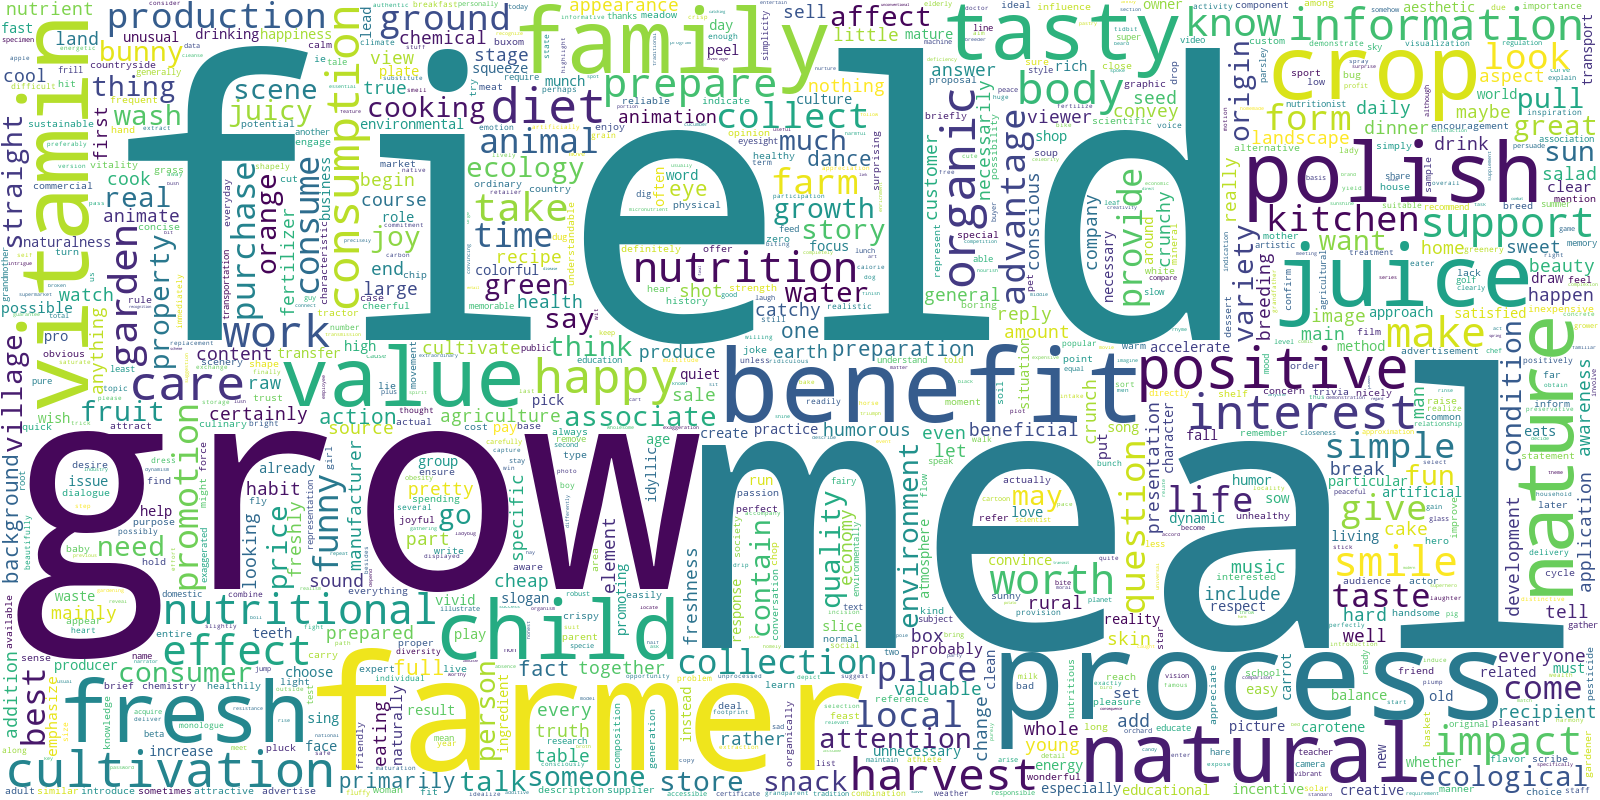

In [58]:
from wordcloud import WordCloud

words = ','.join(list(df_clean['text'].values))
wc = WordCloud(width=1600, height=800, background_color='white', 
               max_words=1000, contour_width=3, contour_color='steelblue', collocations=False)
wc.generate(words)
wc.to_image()

Dalsza część analizy znajduje się w pliku [*lda_algorithm.ipynb*](3_lda_algorithm.ipynb).